In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install flask-ngrok
!pip install flask_cors
!pip install lws==1.2.6

%tensorflow_version 1.x
import tensorflow
import os
from os.path import exists, join, expanduser

# Clone
name = "deepvoice3_pytorch"
if not exists(name):
  ! git clone https://github.com/r9y9/$name
# Change working directory to the project dir 
os.chdir('/content/deepvoice3_pytorch')

!git checkout 7a10ac6763eda92595e257543494b6a95f64229b --quiet



Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 34 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (4,381 kB/s)
debconf: unable to initi

In [ ]:
# Install dependencices
!pip install -q -e '.[bin]'
%pylab inline
! pip install -q librosa nltk
import torch
import numpy as np
import librosa
import librosa.display
import IPython
from IPython.display import Audio
# need this for English text processing frontend
import nltk
! python -m nltk.downloader cmudict

import pytesseract
import shutil
import os
import random
try:
 from PIL import Image
except ImportError:
 import Image
import tensorflow as tf
from flask import Flask, jsonify, make_response, request
from flask import Flask
from flask_cors import CORS, cross_origin
import threading
from skimage import io
from matplotlib.pyplot import imshow ,show
from flask import send_file

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

     |████████████████████████████████| 245kB 3.8MB/s 
     |████████████████████████████████| 122kB 5.1MB/s 
     |████████████████████████████████| 2.1MB 5.4MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 419kB 14.6MB/s 
Populating the interactive namespace from numpy and matplotlib
/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.


In [ ]:
preset = "20180505_deepvoice3_ljspeech.json"
checkpoint_path = "20180505_deepvoice3_checkpoint_step000640000.pth"
if not exists(preset):
  !curl -O -L "https://www.dropbox.com/s/0ck82unm0bo0rxd/20180505_deepvoice3_ljspeech.json"
if not exists(checkpoint_path):
  !curl -O -L "https://www.dropbox.com/s/5ucl9remrwy5oeg/20180505_deepvoice3_checkpoint_step000640000.pth"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  1795  100  1795    0     0   1658      0  0:00:01  0:00:01 --:--:--  4213
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  1076    0  1076    0     0    882      0 --:--:--  0:00:01 --:--:--   882
100  151M  100  151M    0     0  34.7M      0  0:00:04  0:00:04 --:--:-- 59.3M


In [ ]:
import hparams
import json

    
# Load parameters from preset
with open(preset) as f:
  hparams.hparams.parse_json(f.read())
  
# Inject frontend text processor
import synthesis
import train
from deepvoice3_pytorch import frontend
synthesis._frontend = getattr(frontend, "en")
train._frontend =  getattr(frontend, "en")

# alises
fs = hparams.hparams.sample_rate
hop_length = hparams.hparams.hop_size

def tts(model, text, p=0, speaker_id=None, fast=True, figures=True):
  from synthesis import tts as _tts
  waveform, alignment, spectrogram, mel = _tts(model, text, p, speaker_id, fast)
  return waveform

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [ ]:
from train import build_model
from train import restore_parts, load_checkpoint

model = build_model()
model = load_checkpoint(checkpoint_path, model, None, True)

Load checkpoint from: 20180505_deepvoice3_checkpoint_step000640000.pth


In [ ]:
def retriveAudio(img):
  img = img.convert('L')
  img.save('greyscale_noise.jpg')
  threshold=192
  output_image=img
      
  for x in range(output_image.width):
      for y in range(output_image.height):  
          if output_image.getpixel((x,y))< threshold:   
              output_image.putpixel( (x,y), 0 )
          else:    
              output_image.putpixel( (x,y), 255 )
                  
  img=output_image
  img.save('binarized.jpg')
  text = pytesseract.image_to_string(img)

  extractedInformation = text
  textArr=[]
  count=0
  tempStr=""
  splittedText = extractedInformation.split(' ')
  totalLen = len(splittedText)
  for indx,i in enumerate(splittedText):
    tempStr +=i+" "
    count +=1
    if count>=20 or indx==totalLen-1:
      textArr.append(tempStr)
      tempStr=""
      count=0
  # Try your favorite senteneces:)
  texts = textArr
  waveform = np.asarray([])
  print('Converting to Audio')
  for idx, text in enumerate(texts):
    print(text, end=' ')
    temp = tts(model, text, figures=False)
    waveform = numpy.append(waveform,temp)
  IPython.display.display(Audio(waveform, rate=fs,autoplay=True)) 


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://5c8d43766a2c.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [22/May/2021 10:46:42] "OPTIONS /loadAudio HTTP/1.1" 200 -


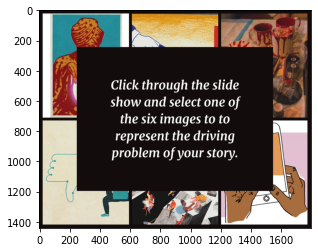

Converting to Audio
 
   
  
  
 

Click through the slide
show and select one of
the six images to  to
represent the driving
problem of your story.

  
  

127.0.0.1 - - [22/May/2021 10:46:51] "POST /loadAudio HTTP/1.1" 200 -
127.0.0.1 - - [22/May/2021 11:06:19] "OPTIONS /loadAudio HTTP/1.1" 200 -


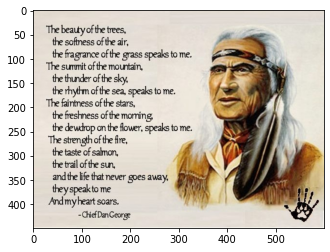

Converting to Audio
The beauty of the tees,
the sofiness of the air,
the fragrance of the grass speaks to me.

‘The summit of the mountain,
the  thunder of the sky,
the rhythm of the sea, specks to me.

‘The fairiness of the stars,
the freshness of the morning,
the dewdrop  on the flower, speaks to me.

The stenghh of the fire,
the taste of saknon,
the trail of the sun,
andthe life that never  goes avay,
they speakto me

Andmybeart soars.

-CHefDanGeorge

   
    
  

127.0.0.1 - - [22/May/2021 11:06:28] "POST /loadAudio HTTP/1.1" 200 -
127.0.0.1 - - [22/May/2021 11:14:48] "OPTIONS /loadAudio HTTP/1.1" 200 -


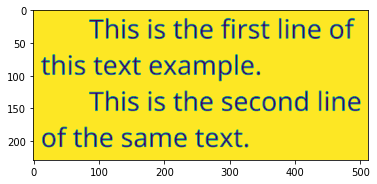

Converting to Audio
This is the first line of
this text example.

This is the second line
of the same text.
  

127.0.0.1 - - [22/May/2021 11:14:51] "POST /loadAudio HTTP/1.1" 200 -
127.0.0.1 - - [22/May/2021 11:16:09] "OPTIONS /loadAudio HTTP/1.1" 200 -


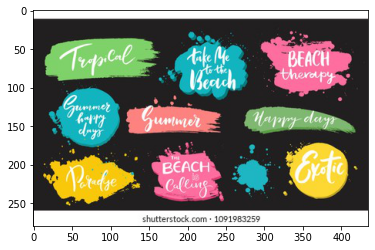

Converting to Audio
 

ym + 1091983259
  

127.0.0.1 - - [22/May/2021 11:16:12] "POST /loadAudio HTTP/1.1" 200 -
127.0.0.1 - - [22/May/2021 11:18:24] "OPTIONS /loadAudio HTTP/1.1" 200 -


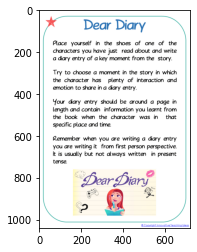

Converting to Audio
Dear Diary

Place yourself in the shoes of one of the
characters you have just read about and write
a dary entry of  akey moment from the story.

Try to choose a moment in the story in which
the character has_ plenty of interaction and
emotion  to share in a dary entry.

Your diary entry should be around a page in
length and contain information you learnt from
the  book when the character was in that
specific place and time.

Remember when you are writing a dary entry
you are writing it  from first person perspective.
It is usually but not always written in present

tense.

Den Dery,

 
  

127.0.0.1 - - [22/May/2021 11:18:38] "POST /loadAudio HTTP/1.1" 200 -
127.0.0.1 - - [22/May/2021 11:18:57] "OPTIONS /loadAudio HTTP/1.1" 200 -


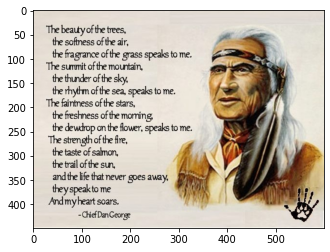

Converting to Audio
The beauty of the tees,
the sofiness of the air,
the fragrance of the grass speaks to me.

‘The summit of the mountain,
the  thunder of the sky,
the rhythm of the sea, specks to me.

‘The fairiness of the stars,
the freshness of the morning,
the dewdrop  on the flower, speaks to me.

The stenghh of the fire,
the taste of saknon,
the trail of the sun,
andthe life that never  goes avay,
they speakto me

Andmybeart soars.

-CHefDanGeorge

   
    
  

127.0.0.1 - - [22/May/2021 11:19:06] "POST /loadAudio HTTP/1.1" 200 -


In [ ]:
from flask import Flask 
from flask_ngrok import run_with_ngrok 
app = Flask(__name__) 
cors = CORS(app)
app.config['CORS_HEADERS'] = 'Content-Type'
run_with_ngrok(app) 

@app.route("/")
@cross_origin()
def hello():
    return "I am alive Affan vhv!"
@app.route('/loadAudio', methods=['POST'])
@cross_origin()
def mytts():
    imgSrc = request.get_json()
    image = io.imread(imgSrc['imgSrc'])
    imshow(image)
    show()
    retriveAudio(Image.fromarray(image))
    return send_file("binarized.jpg", mimetype='image/gif')
	
app.run()
